# Sentiment Analysis Komentar Masyarakat Terhadap Penanggulangan Covid-19

## Import Library

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import json
import nltk

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from wordcloud import WordCloud

from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

from nlp_id.lemmatizer import Lemmatizer
# from nlp_id.tokenizer import Tokenizer
# from nlp_id.tokenizer import PhraseTokenizer
# from nlp_id.postag import PosTag
# from nlp_id.stopword import StopWord

# from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from keras.utils import to_categorical
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn import svm, metrics
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sulth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read Dataset

In [70]:
df = pd.read_csv("Covid19_General.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2269 entries, 0 to 2268
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       2269 non-null   object
 1   Sentiment  2269 non-null   object
dtypes: object(2)
memory usage: 35.6+ KB


In [71]:
df.groupby('Sentiment').describe()

Text                                                               
          count unique                                                top freq
Sentiment                                                                     
neg        1044    909  Tinggal nunggu arus mudik biar covid 19 lebih ...    8
neu         351    318  pak president @jokowi sedang mewabahnya covid ...    3
pos         874    796  WABAH COVID-19  -Di China, rakyatnya saling me...    8

## Pre-Processing

In [72]:
# Text sebelum diproses
print(df.head())

                                                Text Sentiment
0  Yuppp Karena UTANG Pemerintah jg UTANG Bangsa ...       neg
1  Yuks.. kawal kebijakan pemerintah jangan sampa...       pos
2  Yukk sama-sama bahu membahu membantuu pemerint...       pos
3  Yuk sahabat kita samasama menjaga jarak antar ...       pos
4  Yuk sahabat kita sama sama menjaga jarak antar...       pos


In [73]:
# Menghapus data yang terduplikasi
df = df.drop_duplicates()
print(df[df.duplicated()])

Empty DataFrame
Columns: [Text, Sentiment]
Index: []


In [74]:
df.groupby('Sentiment').describe()

Text                                                               
          count unique                                                top freq
Sentiment                                                                     
neg         909    909  Yuppp Karena UTANG Pemerintah jg UTANG Bangsa ...    1
neu         318    318  Yth.pak Presiden @jokowi  Pandemic CoVid-19 in...    1
pos         796    796  Yuks.. kawal kebijakan pemerintah jangan sampa...    1

In [75]:
# Encoding Sentiment dan menghapus neutral
label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])
df = df[df['Sentiment'] != 1]
df.loc[df['Sentiment'] == 2, 'Sentiment'] = 1
df.groupby('Sentiment').describe()

Text                                                               
          count unique                                                top freq
Sentiment                                                                     
0           909    909  Yuppp Karena UTANG Pemerintah jg UTANG Bangsa ...    1
1           796    796  Yuks.. kawal kebijakan pemerintah jangan sampa...    1

In [77]:
# Menyeimbangkan jumlah positif dan negatif sentiment
df_neg = df.loc[df['Sentiment'] == 0].sample(796)
df_pos = df[df['Sentiment'] == 1]
df = pd.concat([df_pos, df_neg], axis=0)
df.groupby('Sentiment').describe()

Text                                                               
          count unique                                                top freq
Sentiment                                                                     
0           796    796  Pemerintah memang ceroboh dalam melakukan pena...    1
1           796    796  Yuks.. kawal kebijakan pemerintah jangan sampa...    1

In [12]:
# Menggunakan Salsabila colloquial dictionary
with open("_json_colloquial-indonesian-lexicon.txt") as f:
    data = f.read()
# Reconstructing data kedalam bentuk 'dict'
df_bhsgaul = json.loads(data)

# Menggunakan Wahid ID-Stopwords
with open('id.stopwords.02.01.2016.txt') as f:
    custom_stop = f.read().splitlines()

In [13]:
lemmatizer = Lemmatizer()
stopwords = stopwords.words('indonesian')
stopwords.extend(custom_stop)

In [14]:
# Cleaning Text
def preprocess_text(text):
    text = re.sub(r"http\S+", "", text)  # menghapus link website
    text = re.sub(r"\S*\d\S*", "", text).strip()  # menghapus nomor
    text = re.sub(r'[^A-Za-z\s]+', ' ', text)  # menghapus selain huruf
    text = text.translate(str.maketrans("", "", string.punctuation))  # menghapus tanda baca
    text = text.lower()  # proses case folding

    # mengganti bahasa gaul dengan kata lengkap
    replacements = df_bhsgaul
    pattern = re.compile(r'\b(' + '|'.join(replacements.keys()) + r')\b')
    text = pattern.sub(lambda x: replacements[x.group()], text)

    # proses penghapusan stopwords
    text = " ".join([word for word in text.split() if word not in stopwords])

    # proses lemmatizer
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = text.strip()
    return text

df['Text Clean'] = df['Text'].apply(lambda x: preprocess_text(x))

In [15]:
# Text setelah diproses
df.head(5)

,Text,Sentiment,Text Clean
1,Yuks.. kawal kebijakan pemerintah jangan sampa...,1,yuk kawal bijak perintah salah tanggung indone...
2,Yukk sama-sama bahu membahu membantuu pemerint...,1,yuk bahu bahu membantuu perintah putus rantai ...
3,Yuk sahabat kita samasama menjaga jarak antar ...,1,yuk sahabat samasama jaga jarak manusia giat r...
4,Yuk sahabat kita sama sama menjaga jarak antar...,1,yuk sahabat jaga jarak manusia giat rumah sesu...
5,yuk pemerintah & penduduk Indonesia kasih wawa...,1,yuk perintah duduk indonesia kasih wawas infor...


In [16]:
# Menentukan Fitur dan Target
X = df['Text Clean'].tolist()
Y = to_categorical(df['Sentiment'])
print("Shape pada sentiment:",Y.shape)

Shape pada sentiment: (1592, 2)


In [17]:
# Tokenizing Text
max_features = 2500
MAX_SEQUENCE_LENGTH = 50

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X)

word_index = tokenizer.word_index
print("Found %s unique tokens" % len(word_index),'\n')
print("Index: "+str(tokenizer.word_index),"\n")

X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating="post")

Found 4503 unique tokens 

Index: {'perintah': 1, 'indonesia': 2, 'lockdown': 3, 'dampak': 4, 'covid': 5, 'rakyat': 6, 'virus': 7, 'ekonomi': 8, 'negara': 9, 'tangan': 10, 'corona': 11, 'kalo': 12, 'orang': 13, 'sebar': 14, 'wabah': 15, 'nya': 16, 'masyarakat': 17, 'ya': 18, 'salah': 19, 'jokowi': 20, 'rumah': 21, 'moga': 22, 'bijak': 23, 'lawan': 24, 'sehat': 25, 'warga': 26, 'pusat': 27, 'bantu': 28, 'cegah': 29, 'kena': 30, 'pikir': 31, 'mari': 32, 'pandemi': 33, 'ikut': 34, 'masuk': 35, 'putus': 36, 'tau': 37, 'sih': 38, 'atas': 39, 'dukung': 40, 'kerja': 41, 'gue': 42, 'atur': 43, 'positif': 44, 'banget': 45, 'cepat': 46, 'hadap': 47, 'jaga': 48, 'daerah': 49, 'presiden': 50, 'lock': 51, 'down': 52, 'korban': 53, 'kasih': 54, 'sosial': 55, 'kayak': 56, 'laku': 57, 'mati': 58, 'tinggal': 59, 'sakit': 60, 'bilang': 61, 'percaya': 62, 'satu': 63, 'lihat': 64, 'tolong': 65, 'china': 66, 'dunia': 67, 'ayo': 68, 'serius': 69, 'lu': 70, 'negeri': 71, 'patuh': 72, 'tambah': 73, 'biar': 74

In [18]:
# Load pre-trained model untuk Word to Vector
path = 'wiki.id.case.model'
model = Word2Vec.load(path)

In [19]:
# Word to Vector
w2v_weights = model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape
print("Size Kamus: {} - Dimensi Embedding: {}".format(vocab_size, embedding_size))

Size Kamus: 37425 - Dimensi Embedding: 100


## WordClouds

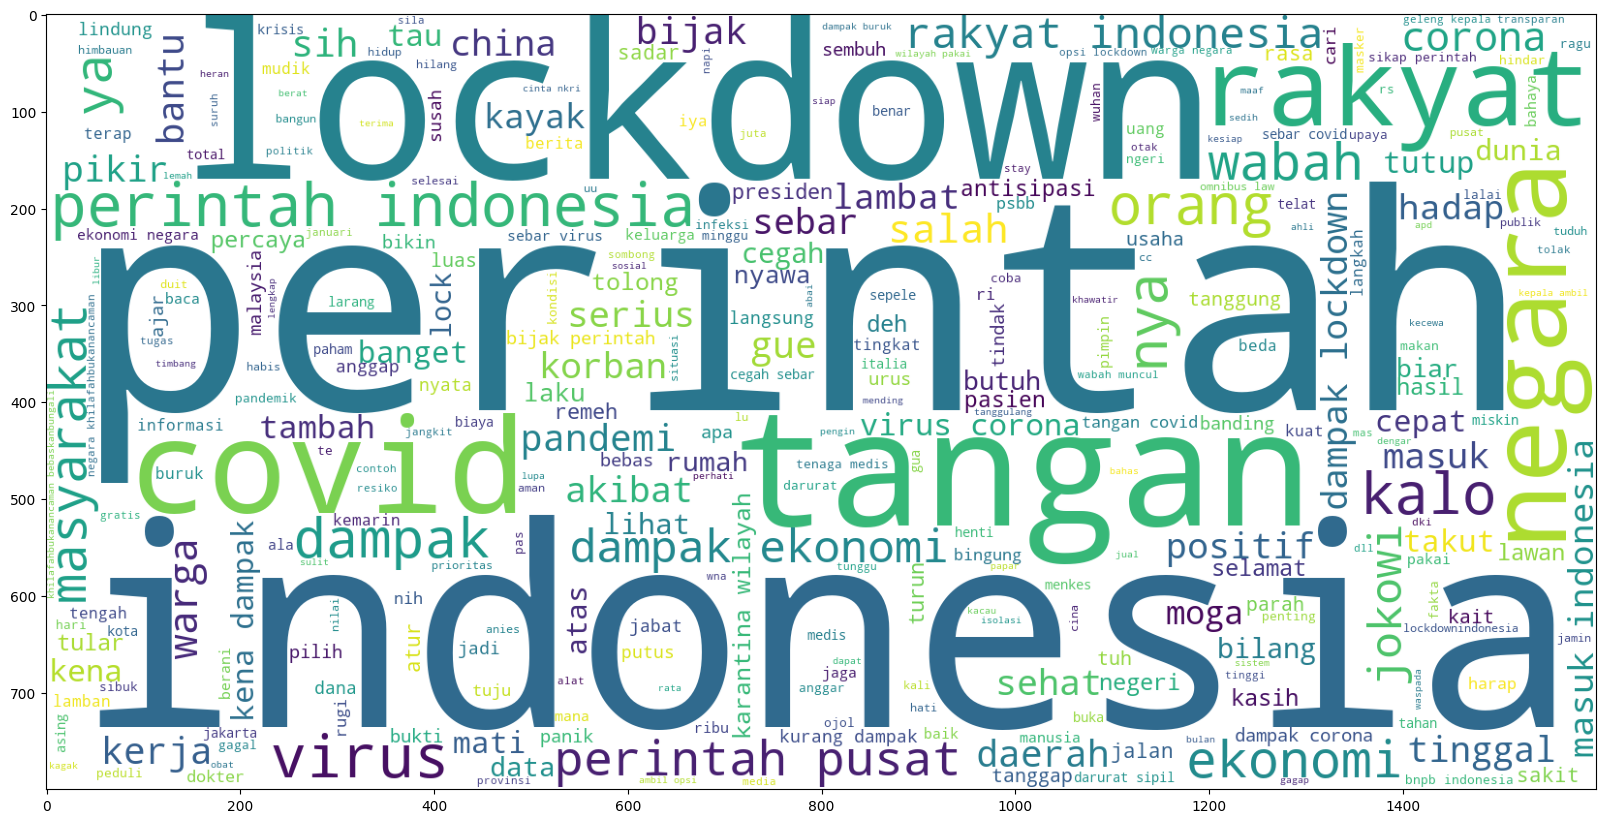

In [20]:
wc1 = WordCloud(max_words=2000, min_font_size=10, height=800, width=1600,
               background_color="white").generate(" ".join(df[df["Sentiment"]==0]['Text Clean']))
plt.figure(figsize=(20,20))
plt.imshow(wc1)

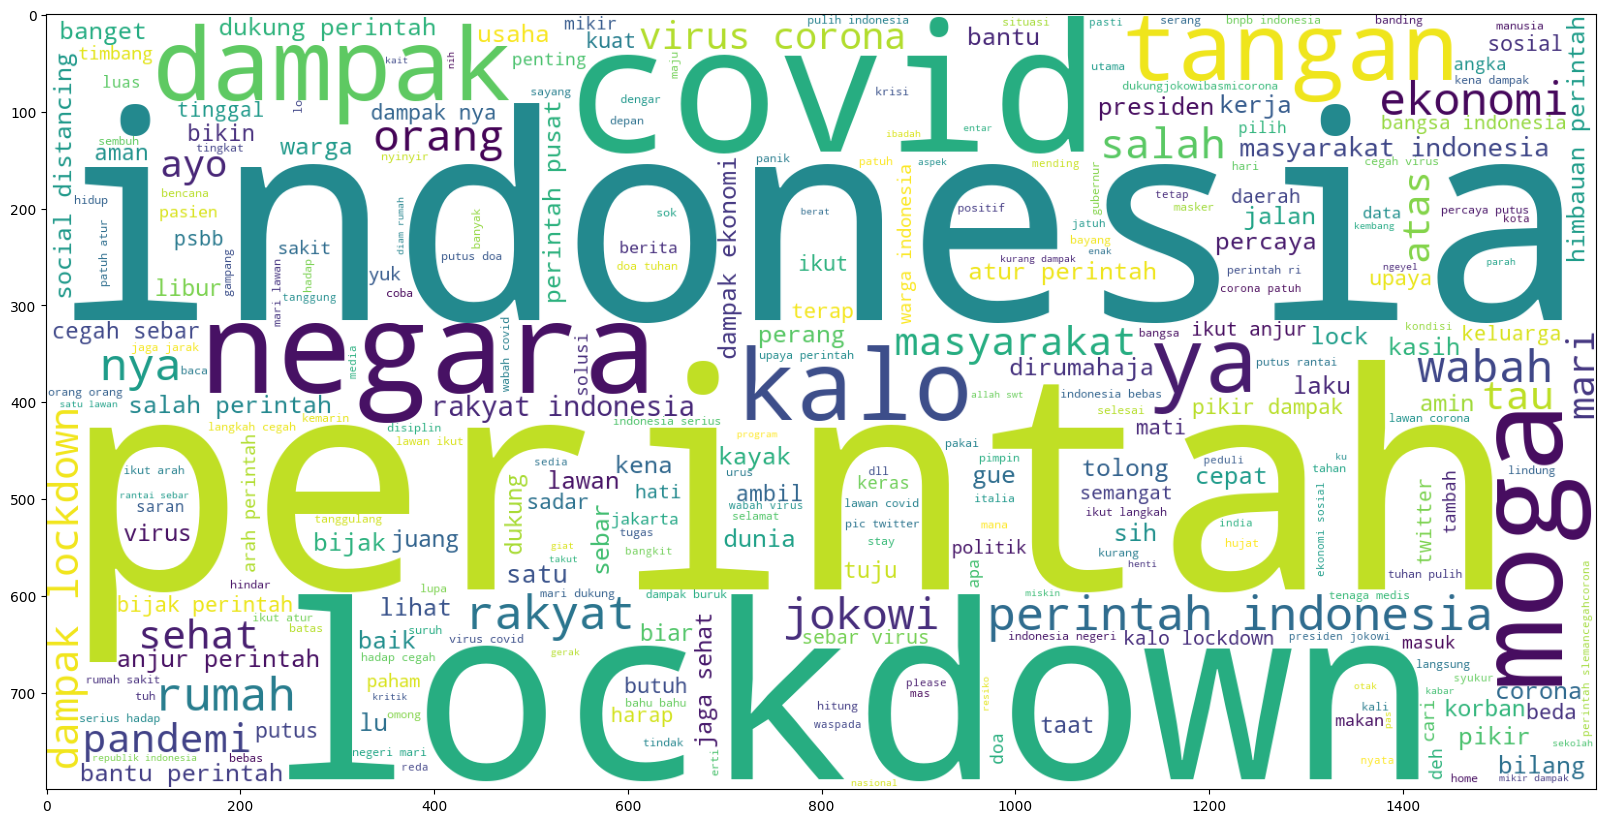

In [21]:
wc2 = WordCloud(max_words=2000, min_font_size=10, height=800, width=1600,
               background_color="white").generate(" ".join(df[df["Sentiment"]==1]['Text Clean']))
plt.figure(figsize=(20,20))
plt.imshow(wc2)

## Data Split

In [22]:
# Split Dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 0, stratify = Y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(1432, 50) (1432, 2)
(160, 50) (160, 2)


## Model Deep Learning

### LSTM

In [23]:
# Membuat model LSTM
model1 = Sequential()
model1.add(Embedding(vocab_size,
                    embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))

model1.add(LSTM(embedding_size, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(2,activation='sigmoid'))
model1.compile(loss = 'binary_crossentropy', optimizer=Adam(learning_rate=0.001),metrics = ['accuracy'])
print(model1.summary())

c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     3,742,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,742,500 (14.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,742,500 (14.28 MB)

None


In [24]:
# Training Data
batch_size = 64
history1 = model1.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), verbose = 1)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.4888 - loss: 0.7063 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5072 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.6943
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4953 - loss: 0.6991 - val_accuracy: 0.5000 - val_loss: 0.6981
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4903 - loss: 0.6952 - val_accuracy: 0.5000 - val_loss: 0.6978
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4735 - loss: 0.7015 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5159 - loss: 0.6955 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5048 - loss: 0.6949 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4770 - loss: 0.6952 - val_accuracy: 0.

In [25]:
# Melakukan prediksi
Y_pred1 = model1.predict(X_test)

# Mengambil kelas dengan probabilitas tertinggi
Y_pred_classes1 = Y_pred1.argmax(axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


In [26]:
# Evaluasi Performansi
df_test1 = pd.DataFrame({'true' : Y_test.tolist(), 'pred':Y_pred_classes1})
df_test1['true'] = df_test1['true'].apply(lambda x: np.argmax(x))
target_names = ['class negatif', 'class positif']
print('Classification Report:')
print(classification_report(df_test1.true, df_test1.pred, target_names=target_names))

Classification Report:
               precision    recall  f1-score   support

class negatif       0.79      0.70      0.74        80
class positif       0.73      0.81      0.77        80

     accuracy                           0.76       160
    macro avg       0.76      0.76      0.76       160
 weighted avg       0.76      0.76      0.76       160



Text(0.5, 1.0, 'Training and Validation Accuracy')

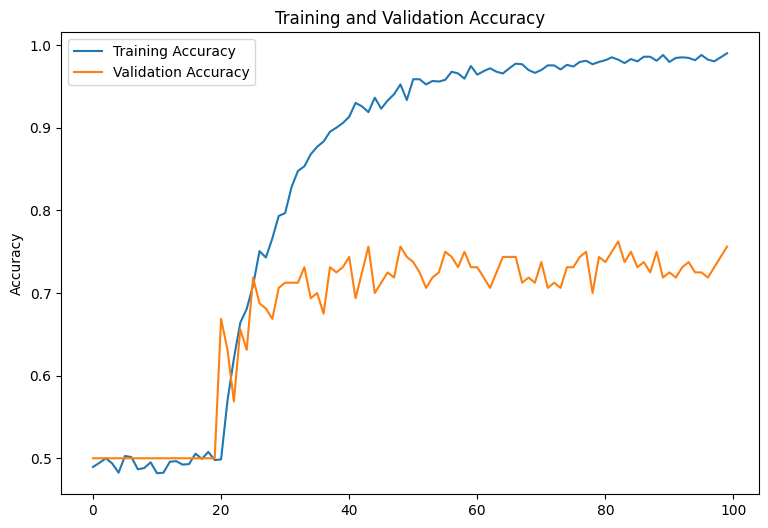

In [27]:
acc = history1.history["accuracy"]
loss = history1.history["loss"]

val_acc = history1.history["val_accuracy"]
val_loss = history1.history["val_loss"]

plt.figure(figsize=(9,6))
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc,label="Validation Accuracy")
plt.legend()
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

In [28]:
# Precision
ps1 = precision_score(df_test1.true, df_test1.pred)
ps1

0.7303370786516854

In [29]:
# Recall
rs1 = recall_score(df_test1.true, df_test1.pred)
rs1

0.8125

In [30]:
# F1 score
f1_1 = f1_score(df_test1.true, df_test1.pred)
f1_1

0.7692307692307693

In [31]:
# Accuracy
acc1 = accuracy_score(df_test1.true, df_test1.pred)
acc1

0.75625

In [32]:
# ROC AUC score
roc1 = roc_auc_score(df_test1.true, df_test1.pred)
roc1

0.7562499999999999

Confusion Matrix RNN: 


Text(50.722222222222214, 0.5, 'Truth')

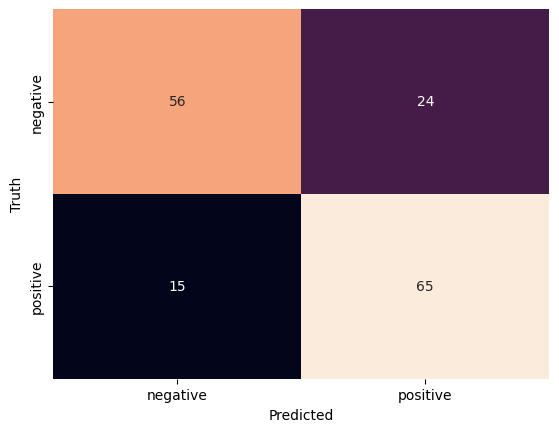

In [33]:
print("Confusion Matrix RNN: ")
labels = ['negative','positive']
sns.heatmap(confusion_matrix(df_test1.true, df_test1.pred), annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Truth")

### BI-LTSM

In [34]:
# Set model Bidirectional LSTM
model2 = Sequential()
model2.add(Embedding(vocab_size,
                    embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))

model2.add(Bidirectional(LSTM(embedding_size, dropout=0.2, recurrent_dropout=0.2)))
model2.add(Dense(2,activation='sigmoid'))
model2.compile(loss = 'binary_crossentropy', optimizer=Adam(learning_rate=0.001),metrics = ['accuracy'])
print(model2.summary())

c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     3,742,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,742,500 (14.28 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,742,500 (14.28 MB)

None


In [35]:
# Training Data
batch_size = 64
history2 = model2.fit(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), verbose = 1)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.5044 - loss: 0.7121 - val_accuracy: 0.6125 - val_loss: 0.6682
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6389 - loss: 0.6518 - val_accuracy: 0.6313 - val_loss: 0.6463
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6685 - loss: 0.6125 - val_accuracy: 0.7125 - val_loss: 0.6163
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7211 - loss: 0.5635 - val_accuracy: 0.6187 - val_loss: 0.6142
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7232 - loss: 0.5371 - val_accuracy: 0.6875 - val_loss: 0.5837
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7984 - loss: 0.4564 - val_accuracy: 0.7250 - val_loss: 0.5386
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8038 - loss: 0.4466 - val_accuracy: 0.7250 - val_loss: 0.5675
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8006 - loss: 0.4236 - val_accuracy: 0.

Text(0.5, 1.0, 'Training and Validation Accuracy')

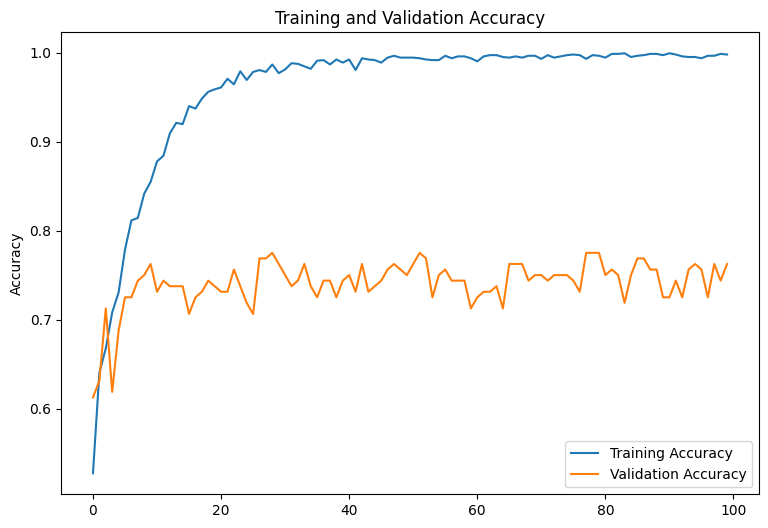

In [36]:
acc = history2.history["accuracy"]
loss = history2.history["loss"]

val_acc = history2.history["val_accuracy"]
val_loss = history2.history["val_loss"]

plt.figure(figsize=(9,6))
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc,label="Validation Accuracy")
plt.legend()
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

In [37]:
# Melakukan prediksi
Y_pred2 = model2.predict(X_test)

# Mengambil kelas dengan probabilitas tertinggi
Y_pred_classes2 = Y_pred2.argmax(axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  


In [38]:
# Evaluasi Performansi
df_test2 = pd.DataFrame({'true' : Y_test.tolist(), 'pred':Y_pred_classes2})
df_test2['true'] = df_test2['true'].apply(lambda x: np.argmax(x))
target_names = ['class negatif', 'class positif']
print('Classification Report:')
print(classification_report(df_test2.true, df_test2.pred, target_names=target_names))

Classification Report:
               precision    recall  f1-score   support

class negatif       0.76      0.78      0.77        80
class positif       0.77      0.75      0.76        80

     accuracy                           0.76       160
    macro avg       0.76      0.76      0.76       160
 weighted avg       0.76      0.76      0.76       160



In [39]:
# Precision
ps2 = precision_score(df_test2.true, df_test2.pred)
ps2

0.7692307692307693

In [40]:
# Recall
rs2 = recall_score(df_test2.true, df_test2.pred)
rs2

0.75

In [41]:
# F1 score
f1_2 = f1_score(df_test2.true, df_test2.pred)
f1_2

0.7594936708860761

In [42]:
# Accuracy
acc2 = accuracy_score(df_test2.true, df_test2.pred)
acc2

0.7625

In [43]:
# ROC AUC score
roc2 = roc_auc_score(df_test2.true, df_test2.pred)
roc2

0.7625

Confusion Matrix RNN: 


Text(50.722222222222214, 0.5, 'Truth')

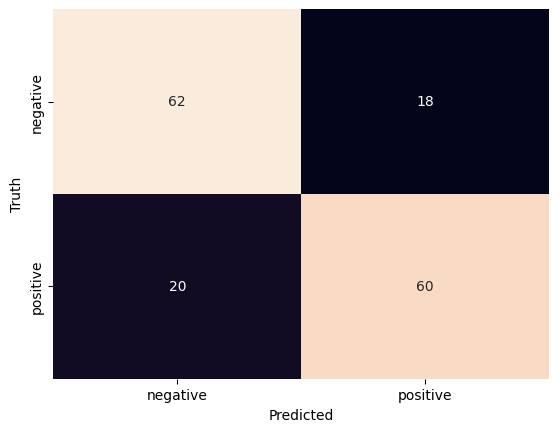

In [44]:
print("Confusion Matrix RNN: ")
labels = ['negative','positive']
sns.heatmap(confusion_matrix(df_test2.true, df_test2.pred), annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Truth")

### Review

In [45]:
accuracies = [acc1, acc2]
roc_scores = [roc1, roc2]
precision_scores = [ps1, ps2]
models = ['LSTM', 'BI-LTSM']

model_df = pd.DataFrame({"Models":models,"Accuracy":accuracies,"Precision Score":precision_scores,"Roc Scores": roc_scores}).sort_values("Roc Scores",ascending=False)
model_df


,Models,Accuracy,Precision Score,Roc Scores
1,BI-LTSM,0.76250,0.769231,0.76250
0,LSTM,0.75625,0.730337,0.75625


## Pre-Processing V.2

In [47]:
X = df['Text Clean']
y = df['Sentiment']

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

In [48]:
if len(np.unique(y)) > 2:
    y = label_binarize(y, classes=np.unique(y))

# Model Machine Learning

## SVM

### Linear

In [49]:
for test_size in [i/10 for i in range(1, 10)]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    clf_linear = svm.SVC(kernel='linear', gamma='auto', probability=True)
    clf_linear.fit(X_train, y_train)
    ypredict = clf_linear.predict(X_test)
    yproba = clf_linear.predict_proba(X_test)

    #printing accuracy,Confusion matrix,Precision and Recall
    print("Train set Accuracy: ", metrics.accuracy_score(y_train, clf_linear.predict(X_train)))
    print("Test set Accuracy: ", metrics.accuracy_score(y_test, ypredict))

    print('\nAccuracy of the classifier is',metrics.accuracy_score(y_test,ypredict))
    print('\nConfusion matrix is:\n',metrics.confusion_matrix(y_test,ypredict))
    print('\nclassification report is:\n',metrics.classification_report(y_test,ypredict))
    print('\nThe value of Precision',metrics.precision_score(y_test,ypredict, pos_label='pos', average='weighted'))
    print('\nThe value of Recall',metrics.recall_score(y_test,ypredict, pos_label='pos', average='weighted'))
    print('\nThe value of F1 Score', metrics.f1_score(y_test, ypredict, average='weighted'))
    if len(np.unique(y)) == 2:
        roc_auc = metrics.roc_auc_score(y_test, yproba[:, 1])
    else:
        roc_auc = metrics.roc_auc_score(y_test, yproba, average='weighted', multi_class='ovr')
    print('\nThe value of ROC AUC Score', roc_auc)
    print("-" * 40)

Train set Accuracy:  1.0
Test set Accuracy:  0.73125

Accuracy of the classifier is 0.73125

Confusion matrix is:
 [[48 20]
 [23 69]]

classification report is:
               precision    recall  f1-score   support

           0       0.68      0.71      0.69        68
           1       0.78      0.75      0.76        92

    accuracy                           0.73       160
   macro avg       0.73      0.73      0.73       160
weighted avg       0.73      0.73      0.73       160


The value of Precision 0.7331104605159043

The value of Recall 0.73125

The value of F1 Score 0.7319229699113639

The value of ROC AUC Score 0.7835677749360613
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'pos') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'pos') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Train set Accuracy:  1.0
Test set Accuracy:  0.7586206896551724

Accuracy of the classifier is 0.7586206896551724

Confusion matrix is:
 [[117  32]
 [ 45 125]]

classification report is:
               precision    recall  f1-score   support

           0       0.72      0.79      0.75       149
           1       0.80      0.74      0.76       170

    accuracy                           0.76       319
   macro avg       0.76      0.76      0.76       319
weighted avg       0.76      0.76      0.76       319


The value of Precision 0.7616345754935695

The value of Recall 0.7586206896551724

The value of F1 Score 0.758867535169552

The value of ROC AUC Score 0.8203711014607185
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'pos') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'pos') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Train set Accuracy:  1.0
Test set Accuracy:  0.7635983263598326

Accuracy of the classifier is 0.7635983263598326

Confusion matrix is:
 [[186  50]
 [ 63 179]]

classification report is:
               precision    recall  f1-score   support

           0       0.75      0.79      0.77       236
           1       0.78      0.74      0.76       242

    accuracy                           0.76       478
   macro avg       0.76      0.76      0.76       478
weighted avg       0.76      0.76      0.76       478


The value of Precision 0.7645412733868364

The value of Recall 0.7635983263598326

The value of F1 Score 0.7635041527336315

The value of ROC AUC Score 0.8270766213755428
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'pos') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'pos') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Train set Accuracy:  1.0
Test set Accuracy:  0.7519623233908949

Accuracy of the classifier is 0.7519623233908949

Confusion matrix is:
 [[235  73]
 [ 85 244]]

classification report is:
               precision    recall  f1-score   support

           0       0.73      0.76      0.75       308
           1       0.77      0.74      0.76       329

    accuracy                           0.75       637
   macro avg       0.75      0.75      0.75       637
weighted avg       0.75      0.75      0.75       637


The value of Precision 0.7526280895760391

The value of Recall 0.7519623233908949

The value of F1 Score 0.7520283545997888

The value of ROC AUC Score 0.8213200173686497
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'pos') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'pos') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Train set Accuracy:  1.0
Test set Accuracy:  0.7537688442211056

Accuracy of the classifier is 0.7537688442211056

Confusion matrix is:
 [[293  89]
 [107 307]]

classification report is:
               precision    recall  f1-score   support

           0       0.73      0.77      0.75       382
           1       0.78      0.74      0.76       414

    accuracy                           0.75       796
   macro avg       0.75      0.75      0.75       796
weighted avg       0.75      0.75      0.75       796


The value of Precision 0.7547356098675195

The value of Recall 0.7537688442211056

The value of F1 Score 0.7538668048968914

The value of ROC AUC Score 0.8154639957508156
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'pos') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'pos') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Train set Accuracy:  1.0
Test set Accuracy:  0.7405857740585774

Accuracy of the classifier is 0.7405857740585774

Confusion matrix is:
 [[348 115]
 [133 360]]

classification report is:
               precision    recall  f1-score   support

           0       0.72      0.75      0.74       463
           1       0.76      0.73      0.74       493

    accuracy                           0.74       956
   macro avg       0.74      0.74      0.74       956
weighted avg       0.74      0.74      0.74       956


The value of Precision 0.7412335107115994

The value of Recall 0.7405857740585774

The value of F1 Score 0.7406470937821068

The value of ROC AUC Score 0.8118978879255583
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'pos') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'pos') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Train set Accuracy:  1.0
Test set Accuracy:  0.7237668161434978

Accuracy of the classifier is 0.7237668161434978

Confusion matrix is:
 [[400 142]
 [166 407]]

classification report is:
               precision    recall  f1-score   support

           0       0.71      0.74      0.72       542
           1       0.74      0.71      0.73       573

    accuracy                           0.72      1115
   macro avg       0.72      0.72      0.72      1115
weighted avg       0.72      0.72      0.72      1115


The value of Precision 0.7245123040221763

The value of Recall 0.7237668161434978

The value of F1 Score 0.7238041456727744

The value of ROC AUC Score 0.7974955404004302
----------------------------------------
Train set Accuracy:  1.0
Test set Accuracy:  0.7127158555729984

Accuracy of the classifier is 0.7127158555729984

Confusion matrix is:
 [[455 170]
 [196 453]]

classification report is:
               precision    recall  f1-score   support

           0       0.70      

c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'pos') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'pos') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'pos') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classifica

Train set Accuracy:  1.0
Test set Accuracy:  0.6413119330076762

Accuracy of the classifier is 0.6413119330076762

Confusion matrix is:
 [[441 277]
 [237 478]]

classification report is:
               precision    recall  f1-score   support

           0       0.65      0.61      0.63       718
           1       0.63      0.67      0.65       715

    accuracy                           0.64      1433
   macro avg       0.64      0.64      0.64      1433
weighted avg       0.64      0.64      0.64      1433


The value of Precision 0.6417956704841493

The value of Recall 0.6413119330076762

The value of F1 Score 0.6410532452412938

The value of ROC AUC Score 0.7129088182012973
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'pos') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1396: UserWarning: Note that pos_label (set to 'pos') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


### RBF

In [50]:
for test_size in [i/10 for i in range(1, 10)]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    clf_rbf = svm.SVC(kernel='rbf', gamma='auto', probability=True)
    clf_rbf.fit(X_train, y_train)
    ypredict = clf_rbf.predict(X_test)
    yproba = clf_rbf.predict_proba(X_test)

    #printing accuracy,Confusion matrix,Precision and Recall
    print("Train set Accuracy: ", metrics.accuracy_score(y_train, clf_rbf.predict(X_train)))
    print("Test set Accuracy: ", metrics.accuracy_score(y_test, ypredict))

    print('\nAccuracy of the classifier is',metrics.accuracy_score(y_test,ypredict))
    print('\nConfusion matrix is:\n',metrics.confusion_matrix(y_test,ypredict))
    print('\nclassification report is:\n',metrics.classification_report(y_test,ypredict))
    print('\nThe value of Precision',metrics.precision_score(y_test,ypredict, pos_label='pos', average='weighted'))
    print('\nThe value of Recall',metrics.recall_score(y_test,ypredict, pos_label='pos', average='weighted'))
    print('\nThe value of F1 Score', metrics.f1_score(y_test, ypredict, average='weighted'))
    if len(np.unique(y)) == 2:
        roc_auc = metrics.roc_auc_score(y_test, yproba[:, 1])
    else:
        roc_auc = metrics.roc_auc_score(y_test, yproba, average='weighted', multi_class='ovr')
    print('\nThe value of ROC AUC Score', roc_auc)
    print("-" * 40)

Train set Accuracy:  0.5083798882681564
Test set Accuracy:  0.425

Accuracy of the classifier is 0.425

Confusion matrix is:
 [[68  0]
 [92  0]]

classification report is:
               precision    recall  f1-score   support

           0       0.42      1.00      0.60        68
           1       0.00      0.00      0.00        92

    accuracy                           0.42       160
   macro avg       0.21      0.50      0.30       160
weighted avg       0.18      0.42      0.25       160


The value of Precision 0.18062499999999998

The value of Recall 0.425

The value of F1 Score 0.2535087719298245

The value of ROC AUC Score 0.8099424552429668
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Train set Accuracy:  0.5082482325216026
Test set Accuracy:  0.4670846394984326

Accuracy of the classifier is 0.4670846394984326

Confusion matrix is:
 [[149   0]
 [170   0]]

classification report is:
               precision    recall  f1-score   support

           0       0.47      1.00      0.64       149
           1       0.00      0.00      0.00       170

    accuracy                           0.47       319
   macro avg       0.23      0.50      0.32       319
weighted avg       0.22      0.47      0.30       319


The value of Precision 0.21816806045538076

The value of Recall 0.4670846394984326

The value of F1 Score 0.2974171422447284

The value of ROC AUC Score 0.19417686537702328
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Train set Accuracy:  0.5026929982046678
Test set Accuracy:  0.49372384937238495

Accuracy of the classifier is 0.49372384937238495

Confusion matrix is:
 [[236   0]
 [242   0]]

classification report is:
               precision    recall  f1-score   support

           0       0.49      1.00      0.66       236
           1       0.00      0.00      0.00       242

    accuracy                           0.49       478
   macro avg       0.25      0.50      0.33       478
weighted avg       0.24      0.49      0.33       478


The value of Precision 0.24376323943908546

The value of Recall 0.49372384937238495

The value of F1 Score 0.32638327297446174

The value of ROC AUC Score 0.5
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Train set Accuracy:  0.5109947643979058
Test set Accuracy:  0.4835164835164835

Accuracy of the classifier is 0.4835164835164835

Confusion matrix is:
 [[308   0]
 [329   0]]

classification report is:
               precision    recall  f1-score   support

           0       0.48      1.00      0.65       308
           1       0.00      0.00      0.00       329

    accuracy                           0.48       637
   macro avg       0.24      0.50      0.33       637
weighted avg       0.23      0.48      0.32       637


The value of Precision 0.2337881898321459

The value of Recall 0.4835164835164835

The value of F1 Score 0.31518111518111513

The value of ROC AUC Score 0.8101093435439941
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Train set Accuracy:  0.5201005025125628
Test set Accuracy:  0.4798994974874372

Accuracy of the classifier is 0.4798994974874372

Confusion matrix is:
 [[382   0]
 [414   0]]

classification report is:
               precision    recall  f1-score   support

           0       0.48      1.00      0.65       382
           1       0.00      0.00      0.00       414

    accuracy                           0.48       796
   macro avg       0.24      0.50      0.32       796
weighted avg       0.23      0.48      0.31       796


The value of Precision 0.23030352768869475

The value of Recall 0.4798994974874372

The value of F1 Score 0.31124211891375386

The value of ROC AUC Score 0.8084515770038192
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Train set Accuracy:  0.5235849056603774
Test set Accuracy:  0.48430962343096234

Accuracy of the classifier is 0.48430962343096234

Confusion matrix is:
 [[463   0]
 [493   0]]

classification report is:
               precision    recall  f1-score   support

           0       0.48      1.00      0.65       463
           1       0.00      0.00      0.00       493

    accuracy                           0.48       956
   macro avg       0.24      0.50      0.33       956
weighted avg       0.23      0.48      0.32       956


The value of Precision 0.23455581134784056

The value of Recall 0.48430962343096234

The value of F1 Score 0.3160470128943419

The value of ROC AUC Score 0.7977604387997845
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Train set Accuracy:  0.5324947589098532
Test set Accuracy:  0.4860986547085202

Accuracy of the classifier is 0.4860986547085202

Confusion matrix is:
 [[542   0]
 [573   0]]

classification report is:
               precision    recall  f1-score   support

           0       0.49      1.00      0.65       542
           1       0.00      0.00      0.00       573

    accuracy                           0.49      1115
   macro avg       0.24      0.50      0.33      1115
weighted avg       0.24      0.49      0.32      1115


The value of Precision 0.23629190210943316

The value of Recall 0.4860986547085202

The value of F1 Score 0.3180029823198768

The value of ROC AUC Score 0.7826243053006446
----------------------------------------
Train set Accuracy:  0.5377358490566038
Test set Accuracy:  0.49058084772370486

Accuracy of the classifier is 0.49058084772370486

Confusion matrix is:
 [[625   0]
 [649   0]]

classification report is:
               precision    recall  f1-score   suppo

c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Train set Accuracy:  0.5094339622641509
Test set Accuracy:  0.4989532449406839

Accuracy of the classifier is 0.4989532449406839

Confusion matrix is:
 [[  0 718]
 [  0 715]]

classification report is:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       718
           1       0.50      1.00      0.67       715

    accuracy                           0.50      1433
   macro avg       0.25      0.50      0.33      1433
weighted avg       0.25      0.50      0.33      1433


The value of Precision 0.2489543406368381

The value of Recall 0.4989532449406839

The value of F1 Score 0.33217092191116293

The value of ROC AUC Score 0.3673335021524437
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

### Poly

In [51]:
for test_size in [i/10 for i in range(1, 10)]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    clf_poly = svm.SVC(kernel='poly', gamma='auto', probability=True)
    clf_poly.fit(X_train, y_train)
    ypredict = clf_poly.predict(X_test)
    yproba = clf_poly.predict_proba(X_test)

    #printing accuracy,Confusion matrix,Precision and Recall
    print("Train set Accuracy: ", metrics.accuracy_score(y_train, clf_poly.predict(X_train)))
    print("Test set Accuracy: ", metrics.accuracy_score(y_test, ypredict))

    print('\nAccuracy of the classifier is',metrics.accuracy_score(y_test,ypredict))
    print('\nConfusion matrix is:\n',metrics.confusion_matrix(y_test,ypredict))
    print('\nclassification report is:\n',metrics.classification_report(y_test,ypredict))
    print('\nThe value of Precision',metrics.precision_score(y_test,ypredict, pos_label='pos', average='weighted'))
    print('\nThe value of Recall',metrics.recall_score(y_test,ypredict, pos_label='pos', average='weighted'))
    print('\nThe value of F1 Score', metrics.f1_score(y_test, ypredict, average='weighted'))
    if len(np.unique(y)) == 2:
        roc_auc = metrics.roc_auc_score(y_test, yproba[:, 1])
    else:
        roc_auc = metrics.roc_auc_score(y_test, yproba, average='weighted', multi_class='ovr')
    print('\nThe value of ROC AUC Score', roc_auc)
    print("-" * 40)

Train set Accuracy:  0.5083798882681564
Test set Accuracy:  0.425

Accuracy of the classifier is 0.425

Confusion matrix is:
 [[68  0]
 [92  0]]

classification report is:
               precision    recall  f1-score   support

           0       0.42      1.00      0.60        68
           1       0.00      0.00      0.00        92

    accuracy                           0.42       160
   macro avg       0.21      0.50      0.30       160
weighted avg       0.18      0.42      0.25       160


The value of Precision 0.18062499999999998

The value of Recall 0.425

The value of F1 Score 0.2535087719298245

The value of ROC AUC Score 0.7786125319693095
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Train set Accuracy:  0.5082482325216026
Test set Accuracy:  0.4670846394984326

Accuracy of the classifier is 0.4670846394984326

Confusion matrix is:
 [[149   0]
 [170   0]]

classification report is:
               precision    recall  f1-score   support

           0       0.47      1.00      0.64       149
           1       0.00      0.00      0.00       170

    accuracy                           0.47       319
   macro avg       0.23      0.50      0.32       319
weighted avg       0.22      0.47      0.30       319


The value of Precision 0.21816806045538076

The value of Recall 0.4670846394984326

The value of F1 Score 0.2974171422447284

The value of ROC AUC Score 0.16221871298855112
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Train set Accuracy:  0.5026929982046678
Test set Accuracy:  0.49372384937238495

Accuracy of the classifier is 0.49372384937238495

Confusion matrix is:
 [[236   0]
 [242   0]]

classification report is:
               precision    recall  f1-score   support

           0       0.49      1.00      0.66       236
           1       0.00      0.00      0.00       242

    accuracy                           0.49       478
   macro avg       0.25      0.50      0.33       478
weighted avg       0.24      0.49      0.33       478


The value of Precision 0.24376323943908546

The value of Recall 0.49372384937238495

The value of F1 Score 0.32638327297446174

The value of ROC AUC Score 0.19097562683849278
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Train set Accuracy:  0.5109947643979058
Test set Accuracy:  0.4835164835164835

Accuracy of the classifier is 0.4835164835164835

Confusion matrix is:
 [[308   0]
 [329   0]]

classification report is:
               precision    recall  f1-score   support

           0       0.48      1.00      0.65       308
           1       0.00      0.00      0.00       329

    accuracy                           0.48       637
   macro avg       0.24      0.50      0.33       637
weighted avg       0.23      0.48      0.32       637


The value of Precision 0.2337881898321459

The value of Recall 0.4835164835164835

The value of F1 Score 0.31518111518111513

The value of ROC AUC Score 0.7919512098843406
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Train set Accuracy:  0.5201005025125628
Test set Accuracy:  0.4798994974874372

Accuracy of the classifier is 0.4798994974874372

Confusion matrix is:
 [[382   0]
 [414   0]]

classification report is:
               precision    recall  f1-score   support

           0       0.48      1.00      0.65       382
           1       0.00      0.00      0.00       414

    accuracy                           0.48       796
   macro avg       0.24      0.50      0.32       796
weighted avg       0.23      0.48      0.31       796


The value of Precision 0.23030352768869475

The value of Recall 0.4798994974874372

The value of F1 Score 0.31124211891375386

The value of ROC AUC Score 0.7600127728456888
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Train set Accuracy:  0.5235849056603774
Test set Accuracy:  0.48430962343096234

Accuracy of the classifier is 0.48430962343096234

Confusion matrix is:
 [[463   0]
 [493   0]]

classification report is:
               precision    recall  f1-score   support

           0       0.48      1.00      0.65       463
           1       0.00      0.00      0.00       493

    accuracy                           0.48       956
   macro avg       0.24      0.50      0.33       956
weighted avg       0.23      0.48      0.32       956


The value of Precision 0.23455581134784056

The value of Recall 0.48430962343096234

The value of F1 Score 0.3160470128943419

The value of ROC AUC Score 0.7629534870476082
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Train set Accuracy:  0.5324947589098532
Test set Accuracy:  0.4860986547085202

Accuracy of the classifier is 0.4860986547085202

Confusion matrix is:
 [[542   0]
 [573   0]]

classification report is:
               precision    recall  f1-score   support

           0       0.49      1.00      0.65       542
           1       0.00      0.00      0.00       573

    accuracy                           0.49      1115
   macro avg       0.24      0.50      0.33      1115
weighted avg       0.24      0.49      0.32      1115


The value of Precision 0.23629190210943316

The value of Recall 0.4860986547085202

The value of F1 Score 0.3180029823198768

The value of ROC AUC Score 0.7121529723150636
----------------------------------------
Train set Accuracy:  0.5377358490566038
Test set Accuracy:  0.49058084772370486

Accuracy of the classifier is 0.49058084772370486

Confusion matrix is:
 [[625   0]
 [649   0]]

classification report is:
               precision    recall  f1-score   suppo

c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Train set Accuracy:  0.5094339622641509
Test set Accuracy:  0.4989532449406839

Accuracy of the classifier is 0.4989532449406839

Confusion matrix is:
 [[  0 718]
 [  0 715]]

classification report is:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       718
           1       0.50      1.00      0.67       715

    accuracy                           0.50      1433
   macro avg       0.25      0.50      0.33      1433
weighted avg       0.25      0.50      0.33      1433


The value of Precision 0.2489543406368381

The value of Recall 0.4989532449406839

The value of F1 Score 0.33217092191116293

The value of ROC AUC Score 0.3664452539104349
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

### Sigmoid

In [52]:
for test_size in [i/10 for i in range(1, 10)]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    clf_sigmoid = svm.SVC(kernel='sigmoid', gamma='auto', probability=True)
    clf_sigmoid.fit(X_train, y_train)
    ypredict = clf_sigmoid.predict(X_test)
    yproba = clf_sigmoid.predict_proba(X_test)

    #printing accuracy,Confusion matrix,Precision and Recall
    print("Train set Accuracy: ", metrics.accuracy_score(y_train, clf_sigmoid.predict(X_train)))
    print("Test set Accuracy: ", metrics.accuracy_score(y_test, ypredict))

    print('\nAccuracy of the classifier is',metrics.accuracy_score(y_test,ypredict))
    print('\nConfusion matrix is:\n',metrics.confusion_matrix(y_test,ypredict))
    print('\nclassification report is:\n',metrics.classification_report(y_test,ypredict))
    print('\nThe value of Precision',metrics.precision_score(y_test,ypredict, pos_label='pos', average='weighted'))
    print('\nThe value of Recall',metrics.recall_score(y_test,ypredict, pos_label='pos', average='weighted'))
    print('\nThe value of F1 Score', metrics.f1_score(y_test, ypredict, average='weighted'))
    if len(np.unique(y)) == 2:
        roc_auc = metrics.roc_auc_score(y_test, yproba[:, 1])
    else:
        roc_auc = metrics.roc_auc_score(y_test, yproba, average='weighted', multi_class='ovr')
    print('\nThe value of ROC AUC Score', roc_auc)
    print("-" * 40)

Train set Accuracy:  0.5083798882681564
Test set Accuracy:  0.425

Accuracy of the classifier is 0.425

Confusion matrix is:
 [[68  0]
 [92  0]]

classification report is:
               precision    recall  f1-score   support

           0       0.42      1.00      0.60        68
           1       0.00      0.00      0.00        92

    accuracy                           0.42       160
   macro avg       0.21      0.50      0.30       160
weighted avg       0.18      0.42      0.25       160


The value of Precision 0.18062499999999998

The value of Recall 0.425

The value of F1 Score 0.2535087719298245

The value of ROC AUC Score 0.8103420716112533
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Train set Accuracy:  0.5082482325216026
Test set Accuracy:  0.4670846394984326

Accuracy of the classifier is 0.4670846394984326

Confusion matrix is:
 [[149   0]
 [170   0]]

classification report is:
               precision    recall  f1-score   support

           0       0.47      1.00      0.64       149
           1       0.00      0.00      0.00       170

    accuracy                           0.47       319
   macro avg       0.23      0.50      0.32       319
weighted avg       0.22      0.47      0.30       319


The value of Precision 0.21816806045538076

The value of Recall 0.4670846394984326

The value of F1 Score 0.2974171422447284

The value of ROC AUC Score 0.5
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Train set Accuracy:  0.5026929982046678
Test set Accuracy:  0.49372384937238495

Accuracy of the classifier is 0.49372384937238495

Confusion matrix is:
 [[236   0]
 [242   0]]

classification report is:
               precision    recall  f1-score   support

           0       0.49      1.00      0.66       236
           1       0.00      0.00      0.00       242

    accuracy                           0.49       478
   macro avg       0.25      0.50      0.33       478
weighted avg       0.24      0.49      0.33       478


The value of Precision 0.24376323943908546

The value of Recall 0.49372384937238495

The value of F1 Score 0.32638327297446174

The value of ROC AUC Score 0.19190362795909793
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Train set Accuracy:  0.5109947643979058
Test set Accuracy:  0.4835164835164835

Accuracy of the classifier is 0.4835164835164835

Confusion matrix is:
 [[308   0]
 [329   0]]

classification report is:
               precision    recall  f1-score   support

           0       0.48      1.00      0.65       308
           1       0.00      0.00      0.00       329

    accuracy                           0.48       637
   macro avg       0.24      0.50      0.33       637
weighted avg       0.23      0.48      0.32       637


The value of Precision 0.2337881898321459

The value of Recall 0.4835164835164835

The value of F1 Score 0.31518111518111513

The value of ROC AUC Score 0.8097047329570126
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Train set Accuracy:  0.5201005025125628
Test set Accuracy:  0.4798994974874372

Accuracy of the classifier is 0.4798994974874372

Confusion matrix is:
 [[382   0]
 [414   0]]

classification report is:
               precision    recall  f1-score   support

           0       0.48      1.00      0.65       382
           1       0.00      0.00      0.00       414

    accuracy                           0.48       796
   macro avg       0.24      0.50      0.32       796
weighted avg       0.23      0.48      0.31       796


The value of Precision 0.23030352768869475

The value of Recall 0.4798994974874372

The value of F1 Score 0.31124211891375386

The value of ROC AUC Score 0.8084073146672737
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Train set Accuracy:  0.5235849056603774
Test set Accuracy:  0.48430962343096234

Accuracy of the classifier is 0.48430962343096234

Confusion matrix is:
 [[463   0]
 [493   0]]

classification report is:
               precision    recall  f1-score   support

           0       0.48      1.00      0.65       463
           1       0.00      0.00      0.00       493

    accuracy                           0.48       956
   macro avg       0.24      0.50      0.33       956
weighted avg       0.23      0.48      0.32       956


The value of Precision 0.23455581134784056

The value of Recall 0.48430962343096234

The value of F1 Score 0.3160470128943419

The value of ROC AUC Score 0.7966126198747914
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Train set Accuracy:  0.5324947589098532
Test set Accuracy:  0.4860986547085202

Accuracy of the classifier is 0.4860986547085202

Confusion matrix is:
 [[542   0]
 [573   0]]

classification report is:
               precision    recall  f1-score   support

           0       0.49      1.00      0.65       542
           1       0.00      0.00      0.00       573

    accuracy                           0.49      1115
   macro avg       0.24      0.50      0.33      1115
weighted avg       0.24      0.49      0.32      1115


The value of Precision 0.23629190210943316

The value of Recall 0.4860986547085202

The value of F1 Score 0.3180029823198768

The value of ROC AUC Score 0.782988157106702
----------------------------------------
Train set Accuracy:  0.5377358490566038
Test set Accuracy:  0.49058084772370486

Accuracy of the classifier is 0.49058084772370486

Confusion matrix is:
 [[625   0]
 [649   0]]

classification report is:
               precision    recall  f1-score   suppor

c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Train set Accuracy:  0.5094339622641509
Test set Accuracy:  0.4989532449406839

Accuracy of the classifier is 0.4989532449406839

Confusion matrix is:
 [[  0 718]
 [  0 715]]

classification report is:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       718
           1       0.50      1.00      0.67       715

    accuracy                           0.50      1433
   macro avg       0.25      0.50      0.33      1433
weighted avg       0.25      0.50      0.33      1433


The value of Precision 0.2489543406368381

The value of Recall 0.4989532449406839

The value of F1 Score 0.33217092191116293

The value of ROC AUC Score 0.3672789605937239
----------------------------------------


c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sulth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

## Logistic Regression

Test size: 0.1
Train set Accuracy:  0.9930167597765364
Test set Accuracy:  0.775

Accuracy:  0.775

Confusion Matrix: 
 [[52 16]
 [20 72]]

Classification Report 
               precision    recall  f1-score   support

           0       0.72      0.76      0.74        68
           1       0.82      0.78      0.80        92

    accuracy                           0.78       160
   macro avg       0.77      0.77      0.77       160
weighted avg       0.78      0.78      0.78       160


Precision:  0.7773989898989899
Recall:  0.775
F1 Score:  0.7757142857142857
ROC AUC Score:  0.8355179028132993
----------------------------------------
Test size: 0.2
Train set Accuracy:  0.992930086410055
Test set Accuracy:  0.768025078369906

Accuracy:  0.768025078369906

Confusion Matrix: 
 [[121  28]
 [ 46 124]]

Classification Report 
               precision    recall  f1-score   support

           0       0.72      0.81      0.77       149
           1       0.82      0.73      0.77       170

 

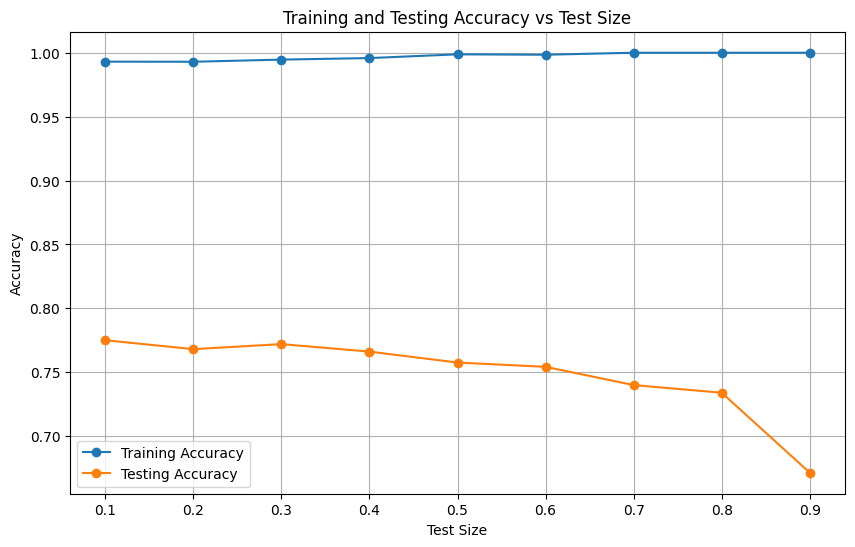

In [53]:
# Menyimpan akurasi untuk setiap ukuran set uji
train_accuracies = []
test_accuracies = []

for test_size in [i / 10 for i in range(1, 10)]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    cm = confusion_matrix(y_test, y_pred)
    cm

    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, y_pred)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Test size: {test_size}")
    print("Train set Accuracy: ", train_acc)
    print("Test set Accuracy: ", test_acc)

    print("\nAccuracy: ", test_acc)
    print("\nConfusion Matrix: \n", cm)
    print("\nClassification Report \n", classification_report(y_test, y_pred))
    print("\nPrecision: ", precision_score(y_test, y_pred, average='weighted'))
    print("Recall: ", recall_score(y_test, y_pred, average='weighted'))
    print("F1 Score: ", f1_score(y_test, y_pred, average='weighted'))

    if len(np.unique(y)) == 2:
        roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    else:
        roc_auc = roc_auc_score(y_test, y_proba, average='weighted', multi_class='ovr')
    print("ROC AUC Score: ", roc_auc)
    print("-" * 40)

# Menampilkan grafik akurasi
test_sizes = [i / 10 for i in range(1, 10)]
plt.figure(figsize=(10, 6))
plt.plot(test_sizes, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(test_sizes, test_accuracies, marker='o', label='Testing Accuracy')
plt.xlabel('Test Size')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy vs Test Size')
plt.legend()
plt.grid(True)
plt.show()

## KNN

In [54]:
for test_size in [i / 10 for i in range(1, 10)]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    k = 10

    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)

    yhat = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    print(f"Test size: {test_size}")
    print("Train set Accuracy: ", metrics.accuracy_score(y_train, model.predict(X_train)))
    print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

    print("\nAccuracy: ", accuracy_score(y_test, yhat))
    print("\nConfusion Matrix: \n", confusion_matrix(y_test, yhat))
    print("\nClassification Report \n", classification_report(y_test, yhat))
    print("\nPrecision: ", precision_score(y_test, yhat, average='weighted'))
    print("Recall: ", recall_score(y_test, yhat, average='weighted'))
    print("F1 Score: ", f1_score(y_test, yhat, average='weighted'))

    if len(np.unique(y)) == 2:
        roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    else:
        roc_auc = roc_auc_score(y_test, y_proba, average='weighted', multi_class='ovr')
    print("ROC AUC Score: ", roc_auc)
    print("-" * 40)

Test size: 0.1
Train set Accuracy:  0.6208100558659218
Test set Accuracy:  0.53125

Accuracy:  0.53125

Confusion Matrix: 
 [[59  9]
 [66 26]]

Classification Report 
               precision    recall  f1-score   support

           0       0.47      0.87      0.61        68
           1       0.74      0.28      0.41        92

    accuracy                           0.53       160
   macro avg       0.61      0.58      0.51       160
weighted avg       0.63      0.53      0.50       160


Precision:  0.627742857142857
Recall:  0.53125
F1 Score:  0.4952776304516339
ROC AUC Score:  0.6438618925831203
----------------------------------------
Test size: 0.2
Train set Accuracy:  0.631578947368421
Test set Accuracy:  0.5454545454545454

Accuracy:  0.5454545454545454

Confusion Matrix: 
 [[122  27]
 [118  52]]

Classification Report 
               precision    recall  f1-score   support

           0       0.51      0.82      0.63       149
           1       0.66      0.31      0.42      

## MultinomialNB

In [55]:
for test_size in [i / 10 for i in range(1, 10)]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    model = MultinomialNB()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    print(f"Test size: {test_size}")
    print("Train set Accuracy: ", accuracy_score(y_train, model.predict(X_train)))
    print("Test set Accuracy: ", accuracy_score(y_test, y_pred))

    print("\nAccuracy: ", accuracy_score(y_test, y_pred))
    print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report \n", classification_report(y_test, y_pred))
    print("\nPrecision: ", precision_score(y_test, y_pred, average='weighted'))
    print("Recall: ", recall_score(y_test, y_pred, average='weighted'))
    print("F1 Score: ", f1_score(y_test, y_pred, average='weighted'))

    if len(np.unique(y)) == 2:
        roc_auc = roc_auc_score(y_test, y_proba[:, 1])
    else:
        roc_auc = roc_auc_score(y_test, y_proba, average='weighted', multi_class='ovr')
    print("ROC AUC Score: ", roc_auc)
    print("-" * 40)

Test size: 0.1
Train set Accuracy:  0.9427374301675978
Test set Accuracy:  0.73125

Accuracy:  0.73125

Confusion Matrix: 
 [[46 22]
 [21 71]]

Classification Report 
               precision    recall  f1-score   support

           0       0.69      0.68      0.68        68
           1       0.76      0.77      0.77        92

    accuracy                           0.73       160
   macro avg       0.73      0.72      0.72       160
weighted avg       0.73      0.73      0.73       160


Precision:  0.7307695393997753
Recall:  0.73125
F1 Score:  0.730980980980981
ROC AUC Score:  0.8566176470588235
----------------------------------------
Test size: 0.2
Train set Accuracy:  0.9552238805970149
Test set Accuracy:  0.7523510971786834

Accuracy:  0.7523510971786834

Confusion Matrix: 
 [[113  36]
 [ 43 127]]

Classification Report 
               precision    recall  f1-score   support

           0       0.72      0.76      0.74       149
           1       0.78      0.75      0.76     